In [830]:
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy.matlib as npm
from scipy import signal
import pandas as pd
from numpy import linalg as LA
from scipy import linalg

In [831]:
class radar1:
    def __init__(self):
        self.fc = 60*(10**9)
        self.fs = 2.64*(10**9)
        self.L = 6272
        self.PRI = 2*(10**-6)
        self.PTM_len = 100
        self.c = 3*(10**8)
        self.ts = 1/self.fs
        self.noise = 0
        self.Lambda = self.c/self.fc
        self.windowsum = 0
        self.ptx = 0
        self.gt = 0
        self.gr = 0
        self.ptx_linear = 10**(self.ptx//10) # This is supposed to be 1 now this 1000 dont know how this works
        self.gt_linear = 10**(self.gt//10)
        self.gr_linear = 10**(self.gr//10)
        self.radar_coeff = (np.sqrt(self.ptx_linear * self.gt_linear * self.gr_linear) * self.Lambda) / (4 * np.pi)

In [832]:
class radar2:
    def __init__(self):
        self.fc = 60*(10**9)
        self.fs = 1.76*(10**9)
        self.L = 512
        self.PRI = 2*(10**-6)
        self.c = 3*(10**8)
        self.ts = 1/self.fs
        self.noise = 1
        self.PTM_len = 100
        self.Lambda = self.c/self.fc
        self.dfd = 121
        self.im_fdmax = 12*(10**3)
        self.im_fdmin = -12*(10**3)
        self.snr = 45 # Variable SNR
        self.snr_linear = 10**(self.snr/10)

In [833]:
class target:
    def __init__(self, range_t, doppler_velocity, rcs_amp):
        self.range = range_t
        self.doppler_velocity = doppler_velocity
        self.rcs_amp = rcs_amp
        self.n_bodypart = 1

In [834]:
class antenna:
    def __init__(self, Lambda, Nelements, DOA):
        self.d_m = Lambda * 0.5
        self.Nelements = Nelements
        self.spacing = np.arange(0, (self.Nelements) * self.d_m, self.d_m)
        self.DOA = DOA # Angle for azimuth

In [875]:
def get_received_signal(target, radar1, xmat1, fs, fc, antenna, n_frame, radar2):
    print("Generating RX Signal + Noise")
    Lvec = radar1.ts * (np.arange(0,radar1.L))
    Mvec = radar1.PRI * np.arange(0,radar1.PTM_len)
    Larray = np.transpose(npm.repmat(Lvec, radar1.PTM_len, 1))
    Marray = npm.repmat(Mvec, radar1.L, 1)
    time_array = Larray + Marray
    
    # with open('time_array_py.npy', 'wb') as f:
    #     np.save(f, time_array)

    w = np.hamming(radar1.PTM_len)
    wmat = npm.repmat(np.transpose(w), radar1.L, 1)
    window_sum = np.sum(w)

    # Channel Modelling
    radar1.ptx = 30
    radar1.gt = 0
    radar1.gr = 0

    rxmat = np.zeros((2*radar1.L-1, radar1.PTM_len))
    rxmat_temp = np.zeros((2*radar1.L-1, radar1.PTM_len))
    range_to_delay_symbols = np.floor(((2*target.range)/radar1.c)/radar1.ts)
    delay_zero = np.zeros((int(range_to_delay_symbols) - 1, int(radar1.PTM_len)))
    suffix_zero = np.zeros((int(radar1.L - range_to_delay_symbols), int(radar1.PTM_len)))

    for nb in range(0,target.n_bodypart):
        velvec = target.doppler_velocity
        Doppler_ele = 2*np.pi*2*velvec/radar1.Lambda
        # Doppler_Delay = np.exp(1j*(Doppler_ele*time_array))
        Doppler_Delay = np.exp(1j*(Doppler_ele*time_array))


        temp = np.multiply(np.multiply(wmat,xmat1),Doppler_Delay)
        amp = (target.rcs_amp/(target.range ** 2))
        rxmat_temp = (amp * 100) * np.concatenate((delay_zero, temp, suffix_zero), dtype = np.complex64)
        rxmat = rxmat + rxmat_temp
    # print(target.n_bodypart)
    rxmat = rxmat/target.n_bodypart
    rxmat = rxmat * radar1.radar_coeff

    # with open('rxmat_py.npy', 'wb') as f:
    #     np.save(f, rxmat)
    
    x_pos = np.argwhere(rxmat != 0)[0][0]
    x_conv = x_pos//1.5
    rxmat_final = rxmat[x_pos:x_pos + radar1.L][:]


    coeff_rx = np.divide(rxmat_final[0:4992][:], xmat1[0:4992][:])
    

    upsamp = np.zeros((2 * len(np.transpose(coeff_rx)[0]), radar1.PTM_len), dtype = np.complex64)
    for i in range(0, radar1.PTM_len):
        np.transpose(upsamp)[i] = signal.resample(np.transpose(coeff_rx)[i], len(upsamp))
    
    downsamp = signal.decimate(upsamp, 3, axis=0)
    
    received_coeff_golay = downsamp[2688:3200][:]

    # with open('received_coeff_golay_py.npy', 'wb') as f:
    #     np.save(f, received_coeff_golay)
    # with open('received_coeff_golay_py.npy', 'wb') as f:
    #     np.save(f, received_coeff_golay)
    
    tx = sio.loadmat("./data/tx_freq_domain.mat")["xmat"]
    xmat = np.transpose(np.transpose(tx)[:100])
    receieved_sg = np.multiply(received_coeff_golay, xmat)

    # with open('receieved_sg_py.npy', 'wb') as f:
    #     np.save(f, receieved_sg)
    rx_mat = np.zeros((1024,100), dtype = np.complex64)
    rx_mat[int(x_conv): int(x_conv) + 512][:] = receieved_sg
    
    # print(radar1.Lambda)
    # print()
    # Make a switch;;; if the DOA > 0 or < 0
    # if antenna.DOA < 0:
    #     antenna_matrix = np.exp(1j * 2 * np.pi * (1/radar1.Lambda) * (np.sin(-antenna.DOA * 2 * np.pi / 360)) * antenna.spacing)
    # else:
    #     antenna_matrix = np.exp(1j * 2 * np.pi * (1/radar1.Lambda) * (np.sin(antenna.DOA * 2 * np.pi / 360)) * antenna.spacing)
    antenna_matrix = np.exp(-1j * 2 * np.pi * (1/radar1.Lambda) * (np.sin(antenna.DOA * 2 * np.pi / 360)) * antenna.spacing)
    antenna_matrix = antenna_matrix.reshape(1, len(antenna_matrix))

    srx_volts = np.zeros((radar1.PTM_len, len(rx_mat), antenna.Nelements), dtype=np.csingle)
    # srx_volts = np.zeros((radar1.PTM_len, len(np.transpose(rx_mat)[0]), ), dtype = np.complex64)
    # srx_volts = np.zeros((len(np.transpose(rx_mat)[0]), antenna.Nelements, radar1.PTM_len), dtype = np.complex64)

    for i in range(0, radar1.PTM_len):
        rxmat_vector = np.transpose(rx_mat)[i].reshape(len(rx_mat), 1)
        srx_volts[i] =  rxmat_vector * antenna_matrix
        # np.transpose(np.transpose(rx_mat)[i].reshape(len(np.transpose(rx_mat)[i]), 1) * antenna_matrix.reshape(1, len(antenna_matrix)))
    # print(np.shape(srx_volts), np.shape(np.transpose(srx_volts, (1, 0, 2))))
    srx_volts = srx_volts.flatten()

    K = 1.38 * 10**-23
    F = 1.76
    Ts = 290 * F
    BW = 2.64 * 10**9

    noise_power = K * Ts * BW
    noise = np.sqrt(noise_power) * (np.random.randn(len(srx_volts)) + 1j * np.random.randn(len(srx_volts)))
    srx_noise = srx_volts + noise
    srx_noise = np.transpose(srx_noise.reshape(radar2.PTM_len, 2 * radar2.L, antenna.Nelements), (1, 2, 0))
    
    # with open('srx_noise_py.npy', 'wb') as f:
    #     np.save(f, srx_noise)
    return srx_noise

In [836]:
def add_doppler_delay(rxmat_fft, doppler_delay):
    rxmat_fft_dd = np.zeros(np.shape(rxmat_fft), dtype=np.csingle)
    for i in range(len(doppler_delay)):
        rxmat_fft_dd[i] = rxmat_fft[i] * doppler_delay[i]
    return np.transpose(rxmat_fft_dd)

In [837]:
def diag_mat_mul(rxmat_dd, xmat_conj):
    diag_res = np.zeros(len(rxmat_dd), dtype=np.csingle)
    for i in range(len(rxmat_dd)):
        diag_res[i] = np.dot(rxmat_dd[i], np.transpose(xmat_conj)[i])
    return diag_res

In [838]:
def matchedfiltering(total_srx_noise, xmat_padded):
    xmat_fft_conj_tran = np.zeros(shape=np.shape(total_srx_noise), dtype=np.csingle)
    rxmat_fft = np.zeros(shape=np.shape(total_srx_noise), dtype=np.csingle)
    
    for i in range(radar1_in.PTM_len):
        rxmat_fft[i] = np.fft.fft(total_srx_noise[i])
        xmat_fft_conj_tran[i] = np.conj(np.fft.fft(xmat_padded[i]))

    y = np.zeros(shape=(radar1_in.PTM_len, len(theta), 2 * radar2_in.L), dtype=np.csingle)

    for i in range(radar1_in.PTM_len):
    # for i in range(1):
        print("iteration:", i)
        for k in range(len(theta)):
            # print("\t\t\tangle:", theta[k])
            theta_k = (2*np.pi*np.sin(np.pi*theta[k]/180))/radar1_in.Lambda
            # doppler_delay = np.diag(np.exp(-1j*theta_k*antenna_param.spacing))
            doppler_delay = np.exp(-1j*theta_k*antenna_param.spacing)
            # y[i][k][:] = np.fft.ifftshift(
            #     np.fft.ifft(
            #         np.diag(np.dot(
            #             np.dot(np.transpose(rxmat_fft[i]), doppler_delay), xmat_fft_conj_tran[i]) 
            #         )
            #     )
            # )
            y[i][k][:] = np.fft.ifftshift(
                np.fft.ifft(
                    diag_mat_mul(
                        add_doppler_delay(rxmat_fft[i], doppler_delay), xmat_fft_conj_tran[i]
                    ) 
                )
            )
    return y

In [839]:
def music(y_res):
        # MUSIC
    # Find max loaction in y_res
    [y_max, x_max] = np.unravel_index(np.argmax(np.abs(y_res[40])), y_res[0].shape)
    print(y_max, x_max)
    no_elements_music = radar1_in.PTM_len
    no_targets = 1
    y_res_max = np.zeros((1, no_elements_music), dtype = np.csingle)

    for i in range(no_elements_music):
        np.transpose(y_res_max)[i] = y_res[i][y_max][x_max]
    # with open("y_res_max_py.npy", "wb") as f:
    #     np.save(f, y_res_max)

    # print(y_res_max.shape)
    y_res_max_tr = np.conj(np.transpose(y_res_max))
    cov_mat = y_res_max_tr * y_res_max
    # cov_mat = np.dot(y_res_max_tr, y_res_max)
    print(np.shape(cov_mat))
    # cov_mat = y_res_max_tr @ y_res_max
    eign_val, eign_vec = linalg.eig(cov_mat)
    eign_val, eign_vec1 = linalg.eig(cov_mat)
    # print(np.shape(eign_val), np.shape(eign_vec))
    noise_subspace_est = np.transpose(np.transpose(eign_vec)[0:no_elements_music-no_targets])
    # noise_subspace_est = eign_vec[0:no_elements_music-no_targets]
    # noise_subspace_est = eign_vec
    # print(np.shape(noise_subspace_est))
    # p_music = np.zeros((len(doppler_axis), 1), dtype=np.csingle)
    p_music = np.zeros((len(doppler_axis), 1))
    # Search for Peak
    for i in range(len(doppler_axis)):
        subspace = np.zeros((1,no_elements_music), dtype=np.csingle)
        for jj in range(no_elements_music):
            np.transpose(subspace)[jj] = np.exp(1j * 2 * np.pi * doppler_axis[i] * radar2_in.PRI * jj)
        # pp1 = subspace @ (noise_subspace_est @ np.transpose(noise_subspace_est)) @ np.transpose(subspace)
        pp1 = np.dot(np.dot(subspace, np.dot(noise_subspace_est, np.transpose(noise_subspace_est))), np.transpose(subspace))
        # pp1 = np.dot(np.dot(np.dot(subspace, noise_subspace_est), np.transpose(noise_subspace_est)), np.transpose(subspace))
        p_music[i] = np.abs(1/pp1)
        # p_music[i] = np.abs(pp1)
    p_music = 10 * np.log10(p_music/np.amax(p_music))
    azimuth_max_x_axis = np.argmax(-p_music)

    return p_music, y_max, x_max, azimuth_max_x_axis

In [881]:
def clean(original_y, xmat_padded, a, b, c, target, radar1, xmat1, antenna, radar2, rxmat_t2):
    measured_range = range_axis[a]
    measured_theta = -theta[b]
    measured_doppler = velocity_axis[c]

    target.range = np.round(measured_range)
    target.doppler_velocity = np.round(measured_doppler)
    antenna.DOA = np.round(measured_theta)

    print(np.round(measured_range))
    print(np.round(measured_doppler))
    print(np.round(measured_theta))

    rxmat_dummy = get_received_signal(target, radar1, xmat1, radar1.fs, radar1.fc, antenna, 1, radar2)
    rxmat_dummy = np.transpose(rxmat_dummy, (2, 1, 0))


    y_new = matchedfiltering(rxmat_dummy, xmat_padded)
    residue_y = original_y - y_new

    with open("y_result_clean.npy", "wb") as f:
        np.save(f, residue_y)
    residue_y = np.load('./y_result_clean.npy')

    y_single_antenna = np.transpose(residue_y[40])
    win_hamm_col = np.hamming(181)
    awin_col = np.sum(win_hamm_col)
    power_y = 10*np.log10(np.abs(y_single_antenna[511:])/awin_col)

    index_max = np.unravel_index(np.argmax(power_y, axis=None), power_y.shape)
    power_y[index_max] = power_y[index_max] + 5
    max_power = power_y[index_max]
    fig, ax = plt.subplots(1,1)
    plot_ra = ax.imshow(np.flip(power_y), cmap="jet", aspect="auto", 
                        vmin=max_power-30, vmax=max_power+5, 
                        extent=[theta[0], theta[::-1][0], range_axis[511:][0], range_axis[511:][::-1][0]])
    fig.colorbar(plot_ra)
    plt.show()
    
    p_music, a, b, c = music(residue_y)

    # Plot Doppler
    fig, ax = plt.subplots(1,1)
    plt.plot(velocity_axis, -p_music - np.amax(-p_music))
    plt.xlim((-90, 90))
    plt.ylim((-5.5, 0.5))
    plt.grid()

In [841]:
radar1_in = radar1()
radar2_in = radar2()


doppler_axis = np.arange(radar2_in.im_fdmin, radar2_in.im_fdmax + radar2_in.dfd, radar2_in.dfd)
velocity_axis = doppler_axis * radar2_in.Lambda/2
delay_axis = np.arange(-radar2_in.L + 1, radar2_in.L)
range_axis = ((radar2_in.c * radar2_in.ts) / 2) * delay_axis
theta = np.arange(-90, 91, 1)

# Load XMAT
xmat1 = sio.loadmat("./data/jrc_tx.mat")["xmat1"]
n_frame = 1

In [842]:
# Target 2
range_t = 10
velocity = 8
rcs_amp = 1
t2 = target(range_t, velocity, rcs_amp)

Nu_elements = 32 # Variable Number of Antenna
DOA_angle = 56 # Default angle
antenna_param = antenna(radar2_in.Lambda, Nu_elements, DOA_angle)


rxmat_t2 = get_received_signal(t2, 
                            radar1_in, 
                            xmat1, 
                            radar1_in.fs, 
                            radar1_in.fc, 
                            antenna_param, 
                            n_frame, 
                            radar2_in)


56
Generating RX Signal + Noise


In [843]:
# Target 1
range_t = 25
velocity = 21
rcs_amp = 1
t1 = target(range_t, velocity, rcs_amp)

Nu_elements = 32 # Variable Number of Antenna
DOA_angle = -42 # Default angle
antenna_param = antenna(radar2_in.Lambda, Nu_elements, DOA_angle)

rxmat_t1 = get_received_signal(t1, 
                            radar1_in, 
                            xmat1, 
                            radar1_in.fs, 
                            radar1_in.fc, 
                            antenna_param, 
                            n_frame, 
                            radar2_in)

-42
Generating RX Signal + Noise


In [844]:
total_srx_noise = np.transpose(rxmat_t1, (2, 1, 0)) + np.transpose(rxmat_t2, (2, 1, 0))
# total_srx_noise = np.transpose(rxmat_t1, (2, 1, 0))
print(total_srx_noise.shape)

(100, 32, 1024)


In [845]:
# Generate Transmitted Wave
tx = sio.loadmat("./data/tx_freq_domain.mat")["xmat"]
xmat = np.transpose(np.transpose(tx)[:100])
xmat_padded1 = np.zeros((1024, 100))
xmat_padded1[:radar2_in.L] = xmat
print(xmat_padded1.shape)
# xmat_padded = np.zeros((1024, 100, antenna_param.Nelements), dtype=np.complex64)
xmat_padded = np.zeros((32, 100, 1024), dtype=np.complex64)

for i in range(antenna_param.Nelements):
    xmat_padded[i] = np.transpose(xmat_padded1)
xmat_padded = np.transpose(xmat_padded, (1, 0, 2))
print(xmat_padded.shape)

(1024, 100)
(100, 32, 1024)


In [846]:
y_total = matchedfiltering(total_srx_noise, xmat_padded)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [847]:
with open("y_result.npy", "wb") as f:
    np.save(f, y_total)

(100, 181, 1024)
(1024, 181)


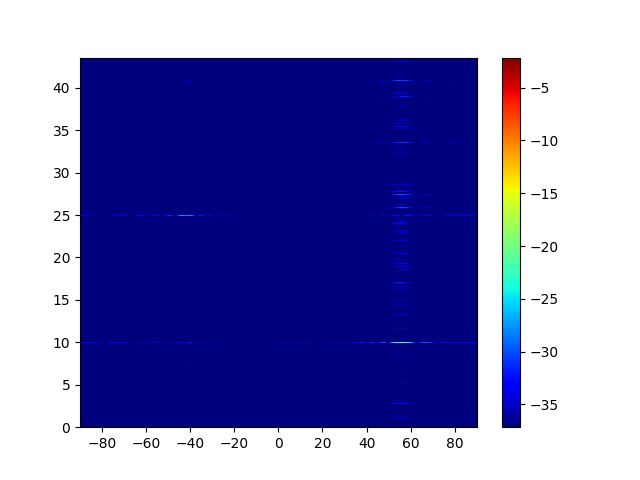

In [848]:
%matplotlib widget

y_res = np.load('./y_result.npy')
print(y_res.shape)
y_antenna = np.transpose(y_res[40])
print(y_antenna.shape)
win_hamm_col = np.hamming(181)
awin_col = np.sum(win_hamm_col)
power_music = 10*np.log10(np.abs(y_antenna[511:])/awin_col)

index_max = np.unravel_index(np.argmax(power_music, axis=None), power_music.shape)
power_music[index_max] = power_music[index_max] + 5
max_power = power_music[index_max]
fig, ax = plt.subplots(1,1)
plot_ra = ax.imshow(np.flip(power_music), cmap="jet", aspect="auto", 
                    vmin=max_power-30, vmax=max_power+5, 
                    extent=[theta[0], theta[::-1][0], range_axis[511:][0], range_axis[511:][::-1][0]])
fig.colorbar(plot_ra)
plt.show()

### MUSIC with Python Results

In [849]:
p_music, a, b, c = music(y_res)

34 628
(100, 100)


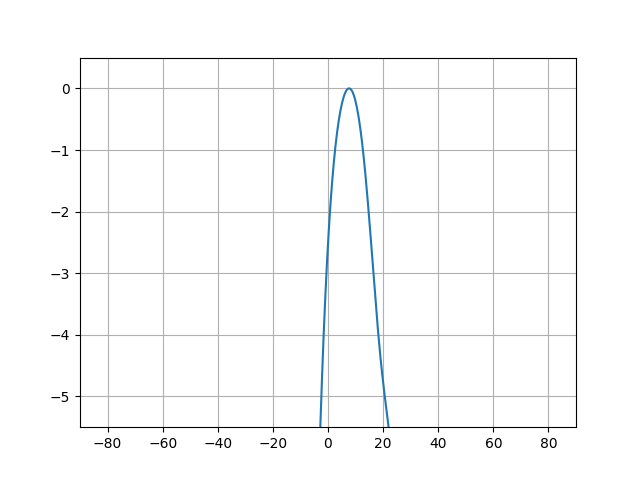

In [852]:
# Plot Doppler
fig, ax = plt.subplots(1,1)
plt.plot(velocity_axis, -p_music - np.amax(-p_music))
plt.xlim((-90, 90))
plt.ylim((-5.5, 0.5))
plt.grid()

### CLEAN Algorithm

10.0
8.0
56
Generating RX Signal + Noise
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
ite

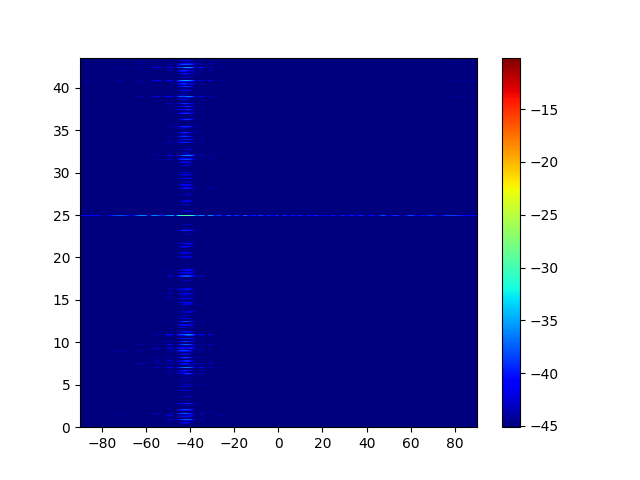

132 804
(100, 100)


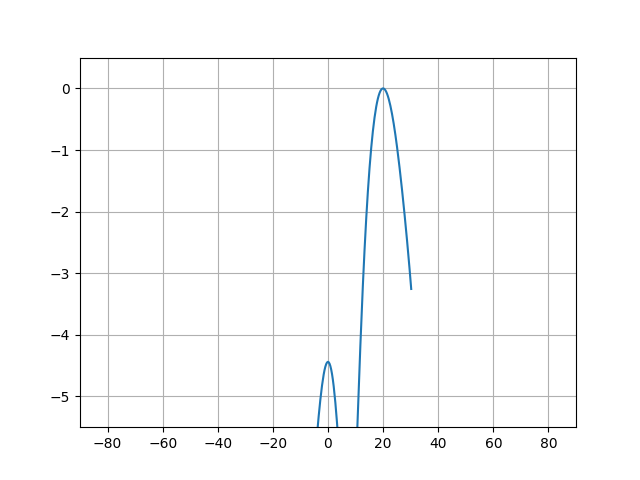

In [882]:
residue_y = clean(y_total, xmat_padded, b, a, c, t1, radar1_in, xmat1, antenna_param, radar2_in, rxmat_t2)